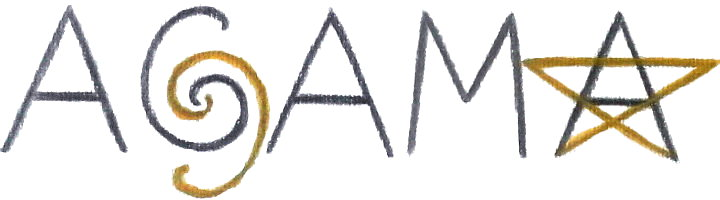
# Tutorial for the Agama stellar-dynamical framework 

In [1]:
import agama, numpy, warnings, matplotlib, matplotlib.pyplot as plt, time
%matplotlib inline
numpy.seterr(all='ignore')
warnings.filterwarnings('ignore')  # disable overflow warnings
plt.rc('figure', figsize = [8.0, 6.0])
plt.rc('figure', dpi = 75)
plt.rc('font', size=12)
plt.rc('legend', fontsize=12)
plt.rc('mathtext', fontset='stix')

## Unit system
By default, `Agama` works in the so-called "N-body units", which are defined by the convention that G=1. This is convenient for many theoretical applications, since stars in a stellar system with a typical mass ~1 and typical size ~1 will have typical velocity ~1. Of course, gravity is a scale-free interaction, thus such a model can be scaled to physical units to represent anything from a globular cluster to a giant elliptical galaxy without changing anything in the internal dynamics. For example, if one sets the length unit to be 1 kpc and the velocity unit - to 1 km/s, then the time unit is 0.98 Gyr and the mass unit computed from the condition G=1 is $2.325\times10^5\,M_\odot$.

However, often it is more convenient to set all three base units (length, velocity and mass, or length, time and mass) independently, which means that $G\ne 1$, or even employ different (but compatible) units for the same physical quantity in different parts of the code (e.g., km/s/kpc and mas/yr, both of which are units of angular velocity). 
`Astropy` provides a very general unit handling subsystem that can address these needs, but it comes with non-negligible overhead costs and requires to write quite verbose code. By contrast, `Agama` implements a much simpler approach, in which the user can select any triplet of base units, and all dimensional quantities passed as input or produced by library routines will be automatically unit-converted inside these routines. This is achieved by calling
```
agama.setUnits(...)
```
at the beginning of the script (and only once). The arguments of this routine are expressed in terms of fiducial "standard" units - length in kpc, velocity in km/s, time in Myr, mass in Msun (exactly two out of the first three need to be provided). For instance, the "Gadget" units commonly used in cosmological simulations are defined by
```
agama.setUnits(length=1, velocity=1, mass=1e10)
```
and if for some reason one wishes to adopt the distance from the Sun to the Galactic center as the length unit and the local circular speed as the velocity unit, then
```
agama.setUnits(length=8, velocity=220, mass=1)
```
does the job.

This routine also accepts `Astropy` units and quantities as input arguments, but this is the *only* exception: all other methods and routines work with plain `numpy` arrays, and the meaning of these physical quantities is determined by the initial unit setup, and conversions between compatible units remain the user's responsibility. For example, if length unit is 1 kpc and velocity unit is 1 km/s, the unit of proper motion turns out to be 0.211 mas/yr.


In [2]:
agama.setUnits(length=1, velocity=1, mass=1)
print("units: %s" % agama.getUnits() + ", G=%g" % agama.G)

units: {'length': 1.0, 'velocity': 1.0, 'time': 977.792221683525, 'mass': 1.0}, G=4.30092e-06


## Potentials
`Agama`has a number of built-in potential and density models (listed in Table 1 of reference.pdf for the list of models and their parameters), and could be augmented with arbitrary user-defined models, as will be discussed later in this tutorial.

One may create a simple potential by providing a list of parameters, or a composite potential from existing objects or from several groups of parameters, or load parameters from an INI file (which may contain several sections with parameters for each component).

Of course, individual components of a composite potential can be indexed, and may themselves turn out to be composite potentials of arbitrary complexity.

In [3]:
pot_names = ['bulge', 'disk', 'halo']
# 1st approach: create separate potential components, then combine
pot_bulge = agama.Potential(type='Dehnen', scaleRadius=1.0, gamma=1.0, mass=2e10)
pot_disk  = agama.Potential(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=5e10)
pot_halo  = agama.Potential(type='NFW', scaleRadius=15.0, mass=5.5e11)
pot_total = agama.Potential(pot_bulge, pot_disk, pot_halo)
print(pot_total)
# extract a single component from a composite potential
print("bulge: %s, pot[0]: %s, they are identical: %s" % (pot_total[0], pot_bulge, pot_total[0]==pot_bulge))

# 2nd approach: create a list of dictionaries with parameters and feed it to the Potential constructor
pot_params = [
    dict(type='Dehnen', scaleRadius=0.5, gamma=1.0, mass=1e10),
    dict(type='MiyamotoNagai', scaleRadius=3.0, scaleHeight=0.3, mass=6e10),
    dict(type='NFW', scaleRadius=16.0, mass=5.5e11)
]
pot_total = agama.Potential(*pot_params)
print(pot_total)

CompositePotential{ Dehnen, MiyamotoNagai, NFW } (symmetry: Axisymmetric)
bulge: Dehnen (symmetry: Spherical), pot[0]: Dehnen (symmetry: Spherical), they are identical: True
CompositePotential{ Dehnen, MiyamotoNagai, NFW } (symmetry: Axisymmetric)


The `Potential` class provides a handful of basic methods, the most fundamental being the computation of density, force ($-\partial\Phi/\partial\boldsymbol{x}$) and force derivatives. Nearly all methods of this and other classes can accept single points or arrays of points as input, and in the latter case, the computations are internally `OpenMP`-parallelized if the array size is large enough to justify this.

Positions and velocities are always given in Cartesian coordinates, so to evaluate the density or potential along the $x$ axis for an array of points $r$ of length $N$, one needs to provide a 2d array of shape $N\times3$: `xyz = numpy.column_stack((r, r*0, r*0))` or something equivalent.

Most high-order "convenience" operations can be expressed in terms of the basic ones, for instance, the circular-velocity curve defined as $v_\mathrm{circ}(R) = \sqrt{R\, \partial\Phi(R,0,0)/\partial R}$.

In [4]:
def scalarize(x):
    return x if len(x)>1 else x[0]

def v_escape(pot, r):
    return scalarize((-pot.potential(numpy.column_stack((r, r*0, r*0))) * 2) ** 0.5)

def v_circ(pot, r):
    return scalarize((-r * pot.force(numpy.column_stack((r, r*0, r*0)))[:,0]) ** 0.5)

gridR = agama.nonuniformGrid(50, 0.01, 30.0)
ax=plt.subplots(1, 2, figsize=(12,5))[1]
ax[0].plot(gridR, v_circ(pot_total, gridR), label='total', color='k')
for i in range(len(pot_total)):
    ax[0].plot(gridR, v_circ(pot_total[i], gridR), label=pot_names[i], color=['r', 'g', 'b'][i])

ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel(r'$v_\mathsf{circ}$ [km/s]')
ax[0].legend(loc='lower right')

ax[1].plot(gridR, v_escape(pot_total, gridR))
ax[1].set_xlabel('R [kpc]')
ax[1].set_ylabel(r'$v_\mathsf{escape}$ [km/s]')
print('Vcirc at 8 kpc = %g km/s, Vescape = %g km/s' % (v_circ(pot_total, 8.0), v_escape(pot_total, 8.0)))


Vcirc at 8 kpc = 227.099 km/s, Vescape = 556.364 km/s


Of course, any potential also provides a method for computing the density, as in the following example.
In fact, one may create density-only models without an associated potential (instances of `agama.Density`), although, of course, it is more interesting to feed these into the Poisson equation and obtain the potential – we'll get to this shortly.

In [5]:
solarRadius = 8.0  # kpc
ax      = plt.subplots(1, 2, figsize=(12, 5))[1]
gridR00 = numpy.column_stack((gridR, gridR*0, gridR*0))    # for the radial profile at z=0
gridz   = agama.symmetricGrid(50, 0.01, 10)
gridR0z = numpy.column_stack((gridz*0 + solarRadius, gridz*0, gridz))  # for the vertical profile at solar radius
for i in range(len(pot_total)):
    ax[0].plot(gridR, pot_total[i].density(gridR00), label=pot_names[i], color=['r', 'g', 'b'][i])
    ax[1].plot(gridz, pot_total[i].density(gridR0z), label=pot_names[i], color=['r', 'g', 'b'][i])
ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel(r'$\rho(R)$ at $z=0$ $[M_\odot/\mathsf{kpc}^3]$')
ax[0].set_yscale('log')
ax[0].set_ylim(1e5,1e10)
ax[0].legend(loc='upper right')
ax[1].set_xlabel('z [kpc]')
ax[1].set_ylabel(r'$\rho(z)$ at %g kpc $[M_\odot/\mathsf{kpc}^3]$' % solarRadius)
ax[1].set_yscale('log')
ax[1].set_ylim(1e3,1e8)
ax[1].legend(loc='upper right')
None

By integrating the density profile along the line of sight, one gets the projected density. The orientation of this line of sight w.r.t. the model coordinate system is specified by three Euler angles $\alpha, \beta, \gamma$ (unfortunately these letters are also used in different contexts, e.g., to denote the power-law indices of the `Spheroid` density profile). See Section A.3 in reference.pdf for details.

The most important in practice is the inclination angle $\beta$, which ranges from 0 for a face-on orientation (with $z$ being the line of sight) to $\pi/2$ for an edge-on orientation (line of sight is in the $x-y$ plane). In the latter case the other angle $\alpha$ specifies the direction of the line of sight within this plane; $\alpha=0$ puts it along the $y$ axis and $\alpha=\pi/2$ – along the $x$ axis.

In [6]:
grid2R, grid2z = numpy.meshgrid(gridR, gridz)  # two 2d arrays of shape (len(gridR), len(gridz))
gridRz = numpy.column_stack((grid2R.reshape(-1), grid2z.reshape(-1)))  # array of shape (len(gridR)*len(gridz), 2)
gridR0 = numpy.column_stack((gridR, gridR*0))  # array of shape (len(gridR), 2)  for the 1d profile
plt.figure(figsize=(12,5))
ax=[plt.axes([0.08,0.1,0.32,0.8]), plt.axes([0.48,0.1,0.5,0.8])]
for i in range(len(pot_total)):
    # face-on, 1d profile
    ax[0].plot(gridR, pot_total[i].projectedDensity(gridR0, beta=0), label=pot_names[i], c=['r','g','b'][i])
    # edge-on, 2d contour plot
    Sigma = pot_total[i].projectedDensity(gridRz, beta=numpy.pi/2).reshape(grid2R.shape)
    ax[1].clabel(ax[1].contour(grid2R, grid2z, numpy.log10(Sigma), levels=numpy.linspace(0, 10, 11),
        cmap=['Reds', 'Greens', 'Blues'][i], vmin=3, vmax=10), fmt='$10^%.0f$')
ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel(r'$\Sigma(R)$ [$M_\odot/\mathsf{kpc}^2$]')
ax[0].set_title('face-on surface density')
ax[0].set_yscale('log')
ax[0].set_ylim(1e5,1e10)
ax[0].legend(loc='upper right')
ax[1].set_xlim(-0.5, 30)
ax[1].set_xlabel('R [kpc]')
ax[1].set_ylabel('z [kpc]')
ax[1].set_title(r'edge-on surface density [$M_\odot/\mathsf{kpc}^2$]')
None

### Optimized potential construction
In the previous example, we used three distinct Galactic components and they correspond to three elements of a composite `Potential` object. Let's now try another Galaxy model, with a Sersic bulge, an exponential disk, and a truncated NFW halo (the 'vanilla' NFW is a rather awkward model with a logarithmically diverging total mass). The latter one is represented by a Spheroid model with $\gamma=1$, $\beta=3$ and $\alpha=1$.

In [7]:
pot_params = [
    dict(type='Sersic', scaleRadius=1.5, mass=2e10, sersicIndex=2.0),
    dict(type='Disk', scaleRadius=2.8, scaleHeight=0.3, mass=5e10),
    dict(type='Spheroid', scaleRadius=20.0, mass=1e12, outerCutoffRadius=250.0, gamma=1, beta=3, alpha=1)
]
pot_total2 = agama.Potential(*pot_params)
print(pot_total2)

CompositePotential{ DiskAnsatz, Multipole } (symmetry: Axisymmetric)


We see, unexpectedly, that the resulting potential contains two rather than three components, and their names bear little resemblance to the original ones.

This is because `agama.Potential` constructor rearranges the input density models and creates a more computationally efficient potential object. In fact, the chosen components are pure density models without an explicit potential counterpart. (You may be surprised why NFW used to have one in the previous example: when we specified an exponential cutoff, it no longer has an analytic expression for the potential, and we had to replace it by a more general Spheroid density-only model. Note that also the `mass` parameter of the NFW model is not the total mass (which is infinite), but the mass within $\sim 5.3\times$ scale radius – see footnote in Section 2.2.4 of reference.pdf; but for the Spheroid model it is really the total mass).

To explain what happens under the hood, let's first create another composite potential with all three galactic components represented separately. This is achieved by iterating over the list of `pot_params` and creating a separate `agama.Potential` for each dictionary from this list, then combining the resulting array into another, top-level instance of Potential:

In [8]:
pot_total3 = agama.Potential(*map(agama.Potential, pot_params))
print(pot_total3)

CompositePotential{ Multipole, CompositePotential{ DiskAnsatz, Multipole }, Multipole } (symmetry: Axisymmetric)


Again the names of these components don't coincide with the input parameters, but at least there are three of them.

The thing is that analytic expressions for the potential are available for some of the simpler density models, but in general this is not possible. Instead, `Agama` uses two very powerful general-purpose methods for solving the Poisson equation, i.e. computing the potential for the given density profile. The one used here is the `Multipole` expansion, in which the density is first decomposed into spherical harmonics with radially-varying amplitudes, then each harmonic term produces its own term in the potential, and the result is synthesized back (much like solving the Poisson equation in Cartesian coordinates via the Fourier transform). 

Two of our input density components (`Sersic` and `Spheroid`) are spherically-symmetric, so they would produce only one multipole term ($l=0$). The `Disk` potential is computed using the technique introduced by Kuijken & Dubinski (1995) and further developed by Dehnen & Binney (1998): namely, it is split into a `DiskAnsatz` part, which is strongly concentrated near the equatorial plane and has analytic expression for the potential, and the residual density profile which is not strongly concentrated and is efficiently represented by spherical harmonics.

You now see why in the previous attempt we obtained only one `Multipole` and one `DiskAnsatz` component: it makes sense to combine all three density profiles into just one instance of a Multipole potential, and that's exactly what happens under the hood. We may illustrate the gain in computational efficiency by comparing the time needed to evaluate the potential for a large number of points in the previous (automatically optimized) case with the manually created three-component potential:

In [9]:
npoints = int(1e7)
points = numpy.random.random(size=(npoints,3))
t1 = time.time()
pot_total2.force(points)
t2 = time.time()
pot_total3.force(points)
t3 = time.time()
print("optimized potential: %.3g eval/s, separate components: %.3g eval/s" % (npoints/(t2-t1), npoints/(t3-t2)))

optimized potential: 3.87e+07 eval/s, separate components: 2.38e+07 eval/s


While the difference is only about a factor $1.5\times$ in this case, it may be more significant if the bulge or the halo were non-spherical, necessitating more expensive higher-order Multipole expansions if instantiated separately.

On the other hand, with the optimized potential, we cannot plot the circular-velocity curve for galactic components separately, so the manually created variant is also useful sometimes.

One should also keep in mind that each `Disk` component creates its own `DiskAnsatz`, which has non-negligible evaluation cost; the popular McMillan(2017) model has four of these! Is it possible to do better – namely, have just one potential component for everything? Yes, but it may not be a `Multipole`: the strongly flattened disky components are poorly represented even with a high-order Multipole expansion.

There is another Poisson solver more suitable for this case, named `CylSpline`. It works by Fourier decomposing the input density profiles (in the axisymmetric case, there is only one $m=0$ term in this expansion), solving the Poisson equation on a rectangular 2d grid in $R,z$ for each Fourier term, and interpolating the result for any point in space between the grid nodes. It is more costly to construct, but comparable to `Multipole` in terms of evaluation efficiency, and greatly exceeds it in accuracy for flattened systems. The only limitation is that it is not working well with very cuspy density profiles, but the NFW and low-$n$ Sersic models should be relatively safe.

In [10]:
t4 = time.time()
dens_total = agama.Density(*pot_params)
pot_total4 = agama.Potential(type='CylSpline', density=dens_total)
t5 = time.time()
pot_total4.force(points)
t6 = time.time()
print('CylSpline potential took %.3f s to construct, runs at %.3g eval/s' % (t5-t4, npoints/(t6-t5)))

CylSpline potential took 0.130 s to construct, runs at 4.19e+07 eval/s


So yes, it runs a bit faster in this case, and the savings will be more significant for larger number of density components crammed into a single potential (as opposed to being treated separately).

Let's check the accuracy of the potential approximation: in absence of the "ground truth" potential model, we are forced to look at the density accuracy.

In [11]:
ax = plt.subplots(1,2,figsize=(12,5))[1]
for pot, label, color in [
    [dens_total, 'input density', 'c'],
    [pot_total2, 'Multipole+DiskAnsatz', 'm'],
    [pot_total4, 'CylSpline', 'y'] ]:
    ax[0].loglog(gridR, pot.density(gridR00), label=label, color=color)
    ax[1].loglog(gridz, pot.density(gridR0z), label=label, color=color)

ax[0].set_xlabel('R [kpc]')
ax[0].set_ylabel(r'$\rho(R)$ at $z=0$ $[M_\odot/\mathsf{kpc}^3]$')
ax[0].legend(loc='lower left')
ax[1].set_xlabel('z [kpc]')
ax[1].set_ylabel(r'$\rho(z)$ at %g kpc $[M_\odot/\mathsf{kpc}^3]$' % solarRadius)
ax[1].legend(loc='lower left')
ax[0].set_xlim(gridR[1], gridR[-1])
ax[1].set_xlim(gridz[len(gridz)//2], gridz[-1])
ax[0].set_ylim(3e5, 3e11)
ax[1].set_ylim(3e6, 3e8)
None

Wow, what are those wiggles? Didn't I promise that `CylSpline` is highly accurate for disky systems?

Well, yes, but we may need to tune its parameters a little.

By default, both `Multipole` and `CylSpline` use grids with 25 nodes in radius (and in $z$ for the latter) – this is usually sufficient to represent even models with a wide dynamical range, since the grid nodes are spaced logarithmically and the potentials are interpolated with 5-th degree splines. The grid extent (`rmin`/`rmax` for both, and additionally `zmin`/`zmax` for the latter) is also determined automatically using some heuristics, but sometimes it may be advantageous to adjust these parameters. 

To find out the automatically selected grid parameters, we export the potential coefficients into a text file and take a look.

In [12]:
pot_total4.export('MWpotCylSpline.ini')
with open('MWPotCylSpline.ini') as f:
    lines = f.readlines()
    print(''.join(lines[:10]))

[Potential]
type=CylSpline
gridSizeR=25
gridSizez=25
mmax=0
symmetry=Axisymmetric
Coefficients
#Phi
0	#m
#R(row)\z(col)	0.0000000000000	0.1465770018021	0.3862145558085	0.7779960534796	1.4185164533555	2.4656980714154	4.1777268239967	6.9767087762350	11.552741717938	19.034060940740	31.265209192183	51.261814482440	83.954102640026	137.40245997193	224.78474681916	367.64534040554	601.20696869678	983.05498458840	1607.3352154941	2627.9659127353	4296.5867797455	7024.6015311611	11484.610770573	18776.243781473	30697.275580197



The long header line shows the nodes in $z$, which are by default the same as in $R$. 
Probably the innermost grid node is a bit too far, and the cuspy density profiles of both bulge and halo deteriorate the accuracy of interpolation in a few adjacent segments, while the outermost node is certainly too far given our halo cutoff radius at 250 kpc.

We can increase the number of nodes and reduce `rmin` to better resolve the problematic inner region, whereas `rmax` may be safely set to 2-3 times the outer cutoff radius.

In [13]:
pot_total5 = agama.Potential(type='CylSpline', density=dens_total, rmin=0.03, rmax=600, gridsizeR=30, gridsizez=30)

In [14]:
ax = plt.subplots(2,2,figsize=(12,10))[1]
for pot, label, color in [
    [dens_total, 'input density', 'c'],
    [pot_total2, 'Multipole+DiskAnsatz', 'm'],
    [pot_total5, 'CylSpline', 'y'] ]:
    ax[0,0].loglog(gridR, pot.density(gridR00), label=label, color=color)
    ax[0,1].loglog(gridz, pot.density(gridR0z), label=label, color=color)
    if pot == dens_total: continue
    ax[1,0].loglog(gridR, abs(pot.density(gridR00) / dens_total.density(gridR00) - 1), label=label, color=color)
    ax[1,1].loglog(gridz, abs(pot.density(gridR0z) / dens_total.density(gridR0z) - 1), label=label, color=color)

ax[0,0].set_xlabel('R [kpc]')
ax[0,0].set_ylabel(r'$\rho(R)$ at $z=0$ $[M_\odot/\mathsf{kpc}^3]$')
ax[0,0].legend(loc='lower left')
ax[0,1].set_xlabel('z [kpc]')
ax[0,1].set_ylabel(r'$\rho(z)$ at %g kpc $[M_\odot/\mathsf{kpc}^3]$' % solarRadius)
ax[0,1].legend(loc='lower left')
ax[1,0].set_ylabel('relative difference')
ax[1,1].set_ylabel('relative difference')
ax[0,0].set_xlim(gridR[1], gridR[-1])
ax[1,0].set_xlim(gridR[1], gridR[-1])
ax[0,1].set_xlim(gridz[len(gridz)//2], gridz[-1])
ax[1,1].set_xlim(gridz[len(gridz)//2], gridz[-1])
ax[0,0].set_ylim(3e5, 3e11)
ax[0,1].set_ylim(3e6, 3e8)
None

Well, that's much better now, with density accuracy at the level of a few percent for `CylSpline`.
Remember that the density is a second derivative of the potential, so the accuracy of the force (first derivative) is much higher than that.

One may be tempted to increase the grid size and resolution even more, but this probably won't help here for two reasons. First, the `CylSpline` potential at grid nodes is computed by numerical integration with a finite target accuracy ($10^{-6}$), so the density computed as the 2nd derivative of slightly noisy potential values has unavoidable numerical noise at a higher level. Second and also related, the interpolation becomes more noise-dominated for small grid spacing (and hence smaller difference between values in adjacent nodes, which themselves carry some error). It is inadvisable to reduce `zmin` below 0.1-0.2 times the disk scale height.

In the above example, `Multipole` in combination with `DiskAnsatz` still fares better, and that's why it is the default approach suitable for most cases, but `CylSpline` is indispensable when one needs to represent a potential of a *custom* flattened model other than `Disk`.

### Custom density and potential models
Whatever large variety of built-in models is, one may need something outside the box. 

`Agama` is designed to be extensible both at the level of the core C++ library (which few users seem to care about) and the Python interface. In particular, one can define custom density and potential functions, which can be used *anywhere* in the code in the same way as the built-in ones. Doing this efficiently, however, is another story.

Let's start with an example of a custom boxy bar density profile – a triaxial Einasto model with equidensity contours being generalized ellipsoids: 
$\rho(x,y,z) = \rho_0 \exp(-d^{1/n})$, where $d=[(x/a)^k + (y/b)^k + (z/c)^k]^{1/k}$. For $k=2$ this is a standard ellipsoid, and this model should be equivalent to the built-in `Spheroid` profile with $\gamma=\beta=0$ and `cutoffStrength`=1/k.

We need to define a function that takes an array of shape $N\times 3$ and returns the density for $N$ points in one call (even if $N=1$, the input array is still two-dimensional). This should be a standalone function (not a class method), and in order to make its parameters adjustable, it is convenient to define an enclosing "factory" function, which takes these parameters, creates and returns the actual density function.

In [15]:
def make_bar_density(rho0, a, b, c, k, n):
    def dens_bar(xyz):
        # generalized ellipse
        r = (abs(xyz[:,0]/a)**k + abs(xyz[:,1]/b)**k + abs(xyz[:,2]/c)**k)**(1./k)
        return rho0 * numpy.exp(-r**(1./n))
    return dens_bar

rho0 = 5e11
r0   = 3e-3
k    = 2.0
n    = 3.0
dens_my  = make_bar_density(rho0, r0, r0, r0, k, n)
print(dens_my)
dens_ein = agama.Density(type='Spheroid', gamma=0, beta=0, outerCutoffRadius=r0, cutoffStrength=1./n, densitynorm=rho0)
# compare the density with the spherical Sersic bulge defined earlier
pot_bulge = pot_total3[0]  # or agama.Potential(pot_params[0])
plt.figure(figsize=(6,4))
#plt.loglog(gridR, pot_bulge.density(gridR00), c='r', label='Sersic')  # the spherical Sersic bulge we created earlier
plt.loglog(gridR, dens_ein .density(gridR00), c='g', label='Einasto')
plt.loglog(gridR, dens_my          (gridR00),  'b+', label='my profile')
plt.xlim(gridR[1], max(gridR))
plt.ylim(3e3, 3e11)
plt.legend(loc='lower left', numpoints=1)
plt.xlabel('r [kpc]')
plt.ylabel(r'$\rho [M\odot/\mathsf{kpc}^3]$')
print("Sersic bulge mass: %.3g, Einasto bulge: %.3g" % (pot_bulge.totalMass(), dens_ein.totalMass()))

<function make_bar_density.<locals>.dens_bar at 0x12f951800>
Sersic bulge mass: 2e+10, Einasto bulge: 2.05e+10


Having ensured that our model is mathematically equivalent to the Einasto profile for $k=2$, we picked up the parameters of the spherical bulge that approximately matches the Sersic bulge defined earlier. Now time to make it non-spherical and boxy, but we want to keep roughly the same spherically averaged density profile and mass.

How do we check the total mass? The `agama.Density` class has a method `totalMass()`, but our model is so far just a lonely Python function that does nothing more than computing the density at the given points. We can wrap it into the `agama.Density` class to enjoy benefits shared by full-fledged built-in models. We need to explicitly specify the symmetry of our density model (in this case, triaxial – first letter is sufficient), because many operations will be more efficient for more symmetric profiles.

If we choose the axis ratio $p=y/x$ and $q=z/x$ and want to keep the overall spherical average the same, we need to multiply all three axes by $(pq)^{-1/3}$, so that their geometric mean remains the same.

In [16]:
axisYtoX = 0.40
axisZtoX = 0.25
r0ell    = r0 * (axisYtoX * axisZtoX)**(-1./3)
k        = 4.0  # boxy shape
dens_my  = make_bar_density(rho0, r0ell, r0ell * axisYtoX, r0ell * axisZtoX, k, n)
dens_bar = agama.Density(dens_my, symmetry='t')
print("Boxy model mass: %.3g" % dens_bar.totalMass())

Boxy model mass: 3.17e+10


Whoops, the mass turned out to be 50% higher than for an ellipsoidal (non-boxy) model, naturally because there is more space inside a boxy ellipse! Let's fix it and also verify that the shape is indeed boxy.

In [17]:
rho0 *= (pot_bulge.totalMass() / dens_bar.totalMass())
dens_bar = agama.Density(make_bar_density(rho0, r0ell, r0ell * axisYtoX, r0ell * axisZtoX, k, n), symmetry='t')
gridx0z = numpy.column_stack((grid2R.reshape(-1), grid2R.reshape(-1)*0, grid2z.reshape(-1)))
gridxy0 = numpy.column_stack((grid2R.reshape(-1), grid2z.reshape(-1), 0*grid2z.reshape(-1)))
ax = plt.subplots(1, 2, figsize=(13.5,4))[1]
ax[0].clabel(ax[0].contour(grid2R, grid2z, numpy.log10(dens_bar.density(gridxy0).reshape(grid2R.shape)),
    levels=numpy.linspace(0, 10, 11), cmap='Reds', vmin=3, vmax=10), fmt='$10^%.0f$')
ax[1].clabel(ax[1].contour(grid2R, grid2z, numpy.log10(dens_bar.density(gridx0z).reshape(grid2R.shape)),
    levels=numpy.linspace(0, 10, 11), cmap='Reds', vmin=3, vmax=10), fmt='$10^%.0f$')
ax[0].set_xlim(-0.5, 30)
ax[1].set_xlim(-0.5, 30)
ax[0].set_xlabel('x [kpc]')
ax[0].set_ylabel('y [kpc]')
ax[1].set_xlabel('x [kpc]')
ax[1].set_ylabel('z [kpc]')
ax[0].set_title(r'face-on in-plane density [$M_\odot/\mathsf{kpc}^3$]')
ax[1].set_title(r'edge-on in-plane density [$M_\odot/\mathsf{kpc}^3$]')
print("Boxy model mass: %.3g" % dens_bar.totalMass())

Boxy model mass: 2e+10


Alright, let's now look at the surface density. We would normally use the same method
```
dens_bar.projectedDensity(...)
```
as for a built-in model, but if you try this, it will be *very* slow. The reason is, of course, that our function is defined in Python, and the integration along a single line of sight needs to evaluate it hundreds if not thousands of times – every time passing the control flow from the C++ core to the Python user-defined function and back, which isn't fast at all.

To get around this problem, and also to make our bar model more powerful in practice, we will construct a `Multipole` potential from it, much in the same way as for any built-in model (in fact, we may pass the original Python function `dens_my` or wrap it into `agama.Density` beforehand – the result is identical).

For this rather flattened model, the order of `Multipole` expansion needs to be ramped up to provide sufficient accuracy. By default, the Fourier expansion in $\phi$ stops at `mmax`=6, and so does the spherical-harmonic expansion in $\theta$ parametrized by `lmax`. We may certainly increase the latter to something like 10-16, and the cost of potential evaluation is nearly independent of it; however, it scales almost linearly with `mmax` (plus a fixed overhead), so we might need to restrict it to a lower order. Meanwhile, if we were to use a `CylSpline` potential solver instead of `Multipole`, these considerations still apply, but `mmax` above 12 is *considerably* more expensive to construct for a technical reason.

In [18]:
pot_bar = agama.Potential(type='Multipole', density=dens_bar, lmax=20, mmax=10)
ax = plt.subplots(1, 2, figsize=(13.5,4))[1]
for mod, label, cmap in [
    [dens_bar, 'original', 'Reds'],
    [pot_bar , 'Multipole', 'Blues'] ]:
    ax[0].contour(grid2R, grid2z, numpy.log10(mod.density(gridxy0).reshape(grid2R.shape)),
        levels=numpy.linspace(0, 10, 11), cmap=cmap, vmin=3, vmax=10)
    ax[1].contour(grid2R, grid2z, numpy.log10(mod.density(gridx0z).reshape(grid2R.shape)),
        levels=numpy.linspace(0, 10, 11), cmap=cmap, vmin=3, vmax=10)
    ax[1].plot([0], [0], color=plt.get_cmap(cmap)(0.5), label=label)
ax[0].set_xlabel('x [kpc]')
ax[0].set_ylabel('y [kpc]')
ax[1].set_xlabel('x [kpc]')
ax[1].set_ylabel('z [kpc]')
ax[0].set_title(r'face-on in-plane density [$M_\odot/\mathsf{kpc}^3$]')
ax[1].set_title(r'edge-on in-plane density [$M_\odot/\mathsf{kpc}^3$]')
ax[1].legend(loc='upper right')
print("Boxy model mass: %.3g, Multipole approximation: %.3g" % (dens_bar.totalMass(), pot_bar.totalMass()))

Boxy model mass: 2e+10, Multipole approximation: 2e+10


Well, looks tolerable (remember that the potential and forces are better approximated than the density). 

Let's now look at the circular-velocity curve of this bar and compare it with the spherical Sersic bulge defined earlier.

In [19]:
plt.figure(figsize=(6,4))
plt.plot(gridR, v_circ(pot_bulge, gridR), label='spherical Sersic', c='r')
plt.plot(gridR, v_circ(pot_bar  , gridR), label='boxy Einasto', c='b', dashes=[5,4])
plt.xlabel('R [kpc]')
plt.ylabel(r'$v_\mathsf{circ}$ [km/s]')
plt.legend(loc='lower right')
None

Hmm, doesn't quite look identical, despite our efforts to match the sphericalized density profile. It feels like its total mass is higher, but we've checked that it is the same!

But this plot is actually misleading, because we computed the "circular velocity" from the force along the $x$ axis, which in a triaxial potential is not quite the same as the azimuthally-averaged radial force (the best proxy for the circular velocity).

To fix this, we may create another version of "bar potential", except that it will be forced to be axisymmetric by keeping `mmax=0`. We can do this either from the original density model, or from the already existing triaxial `Multipole` potential – the result should be very similar (up to the choice of grid nodes, which we left to be decided automatically).

In [20]:
pot_bar_axi1 = agama.Potential(type='Multipole', density=dens_bar,  lmax=20, mmax=0)   # bar_axi is a kind of oxymoron..
pot_bar_axi2 = agama.Potential(type='Multipole', potential=pot_bar, lmax=20, mmax=0)
plt.figure(figsize=(6,4))
plt.plot(gridR, v_circ(pot_bulge,    gridR), label='spherical Sersic', c='r')
plt.plot(gridR, v_circ(pot_bar  ,    gridR), label='boxy Einasto', c='b', dashes=[5,4])
plt.plot(gridR, v_circ(pot_bar_axi1, gridR), label='axisym bar 1', c='g')
plt.plot(gridR, v_circ(pot_bar_axi2, gridR), label='axisym bar 2', c='m', dashes=[6,5])
plt.xlabel('R [kpc]')
plt.ylabel(r'$v_\mathsf{circ}$ [km/s]')
plt.legend(loc='lower right')
None

Now the peak value is still below that of a spherical model (because ours is a flattened axisymmetric one), but at least it approaches it asymptotically at large radii much faster than when we incorrectly evaluate it only along the $x$ axis.

### Potentials from an N-body snapshot
The general-purpose potential solvers in `Agama` (`Multipole`, `CylSpline`, and another method not mentioned before, `BasisSet`) can be constructed either from analytic density profiles or from N-body snapshots. For instance, one may take particle positions and masses from an N-body simulation, create a smooth approximation of the galaxy potential, and integrate particle orbits in a frozen potential (assuming that the system is reasonably close to stationary; the smooth potential may be rotating, as discussed below), or compute actions for all particles in the snapshot, etc.

Naturally, these potential expansions have a finite spatial resolution: for `Multipole`, the radial resolution is determined by the log-spaced grid in spherical radius, and the angular resolution – by the order of spherical-harmonic expansion (roughly speaking, $2\pi/l_\mathrm{max}$ for $\theta$ and $2\pi/m_\mathrm{max}$ for $\phi$); for `CylSpline`, there are separate grids in $R$ and $z$, and the azimuthal resolution is again set by $m_\mathrm{max}$. While it may be possible to resolve clumps and other substructures at scales above the resolution limit, this is not what these potential expansions are designed for: the goal is to represent the large-scale features of a single well-shaped stellar system and ignore (smooth out) small-scale ones. Moreover, one can explicitly enforce various degrees of symmetry: for instance, setting $m_\mathrm{max}=0$ will retain only the axisymmetric part of the potential, and one does not need to randomize azimuthal angles of particles to achieve this. This is controlled by the `symmetry='...'` parameter, with possible variants listed in Table 5 of `reference.pdf`, e.g. `spherical`, `axisymmetric`, `triaxial` (the latter assumes that the principal axes are aligned with $x$, $y$, $z$).

One thing to keep in mind is that the smooth potential constructed from an N-body system is inherently noisy (although not as much as the "true" N-body potential, but still more than a potential expansion created from an analytic density profile). For a given number of particles, there is a practical limit on the resolution (grid size and order of expansion), beyond which the potential will be dominated by discreteness noise and the approximation accuracy will deteriorate rather than improve. The default parameters (25 grid points and order of angular expansion equal to 6) are reasonable in many cases, at least if the snapshot contains $\gtrsim 10^5$ particles, but may need to be adjusted on a case-to-case basis. By default, the location of the first/last grid nodes are automatically determined from the particle distribution, but this heuristic approach might not give optimal results, and it's recommended to experiment with manually set parameters. For instance, the vertical resolution of `CylSpline` (the smallest grid segment set by `zmin`) should not be much smaller than the scale height of a stellar disk (this also applies to an analytic density profile). And it is very important that the snapshot is centered at origin and (especially for the `CylSpline` case) aligned with principal axes. 

The density provided by potential expansions constructed from an N-body snapshot may not be sufficiently accurate: being the second derivative of the potential, it is considerably more affected by discreteness noise than the potential itself and its first derivative (acceleration), both of which should be expected to be well approximated.

In the following example, we first create an N-body snapshot by sampling our analytic density profile with equal-mass particles with positions randomly drawn from the probability distribution $\rho(\boldsymbol{x})$. Note that this snapshot has no velocity information and is therefore not a system in dynamical equilibrium – creating the latter is a much more complex task, which can also be addressed by `Agama`, but that's another story. For the moment, we only use these positions and masses of particles to visually represent their distribution by a scatterplot, and then to construct a `Multipole` potential from a snapshot, which does resemble the analytic one fairly well.

In [21]:
numpy.set_printoptions(linewidth=100, precision=6, threshold=100, suppress=True)
pos, mass = dens_bar.sample(1000000)
print(pos)
print(mass)
print('created an array of particle coordinates (shape %s) and masses (shape %s)' % (pos.shape, mass.shape))
pot_bar_nbody = agama.Potential(type='Multipole', particles=(pos, mass), symmetry='triaxial', lmax=20, mmax=10)
print('created a Multipole potential from particles; total mass=%.4g=%.4g' %
    (numpy.sum(mass), pot_bar_nbody.totalMass()))
# plot the snapshot viewed edge-on and the 2d contour plot of projected density
ax=plt.subplots(1, 2, figsize=(16,3.75))[1]
ax[0].scatter(pos[:,0], pos[:,2], s=1, linewidths=0, edgecolors='none', c='gray', alpha=0.1, rasterized=True)
Sigma = pot_bar_nbody.projectedDensity(gridRz, beta=numpy.pi/2).reshape(grid2R.shape)
ax[0].contour(grid2R, grid2z, numpy.log10(Sigma), levels=numpy.linspace(5, 10, 11), cmap='Blues', vmin=5, vmax=10)
ax[0].set_xlim(-6, 6)
ax[0].set_ylim(-3, 3)
ax[0].set_xlabel('X [kpc]')
ax[0].set_ylabel('Z [kpc]')
ax[0].set_title(r'surface density  [$M_\odot/\mathsf{kpc}^2$]')
# plot the density in the y=0 plane (original analytic profile, its Multipole approximation,
# and the Multipole constructed from an N-body snapshot)
for mod, label, cmap, linestyle in [
    [dens_bar, 'analytic original', 'Reds', '-'],
    [pot_bar , 'analytic Multipole', 'Blues', '-'],
    [pot_bar_nbody, 'N-body Multipole', 'Greens', '--']]:
    ax[1].contour(grid2R, grid2z, numpy.log10(mod.density(gridx0z).reshape(grid2R.shape)),
        levels=numpy.linspace(0, 10, 11), cmap=cmap, vmin=3, vmax=10, linestyles=linestyle)
    ax[1].plot([0], [0], color=plt.get_cmap(cmap)(0.5), label=label)
ax[1].set_xlim(0, 24)
ax[1].set_ylim(-6, 6)
ax[1].set_xlabel('x [kpc]')
ax[1].set_ylabel('z [kpc]')
ax[1].set_title(r'in-plane density [$M_\odot/\mathsf{kpc}^3$]')
ax[1].legend(loc='upper right')
None

[[-9.424342 -9.41712  -0.087892]
 [-1.84049   0.299798  0.134729]
 [ 0.274143 -0.051429  0.090701]
 ...
 [ 0.353714 -0.1925    0.206431]
 [ 3.845419  3.884107  0.958336]
 [ 1.855448 -0.688666  0.7658  ]]
[19998.197448 19998.197448 19998.197448 ... 19998.197448 19998.197448 19998.197448]
created an array of particle coordinates (shape (1000000, 3)) and masses (shape (1000000,))
created a Multipole potential from particles; total mass=2e+10=2e+10


In fact, the density of the two `Multipole` expansions (created from the original analytic profile or from its N-body representation) are so similar as to be nearly indistinguishable; clearly, in this case the discreteness noise is still sub-dominant to the errors caused by a finite order of expansion. We can quantify it by computing the distribution of relative errors in density: the average error is slightly larger for the N-body case, but the tail of higher errors is nearly the same (and these appear only in the very-low-density outer regions).

In [22]:
dens_true = dens_bar.density(pos[::100])
dens_multipole_analytic = pot_bar.density(pos[::100])
dens_multipole_nbody = pot_bar_nbody.density(pos[::100])
err_analytic = abs(dens_multipole_analytic / dens_true - 1)
err_nbody    = abs(dens_multipole_nbody    / dens_true - 1)
err_bins = numpy.logspace(-4,0,41)
plt.figure(figsize=(6,4))
plt.hist(err_analytic, bins=err_bins, histtype='step', label='analytic Multipole', color='b')
plt.hist(err_nbody,    bins=err_bins, histtype='step', label='N-body Multipole', color='r')
plt.legend(loc='upper left')
plt.xlabel('relative error in density')
plt.gca().set_yticklabels([])
plt.xscale('log')

### Density/Potential modifiers
All potentials considered so far were static, which is the most common usage scenario.
Even in this case, orbits can be computed in a rotating reference frame, as we will discuss shortly.

But sometimes one needs to consider a system of two galaxies moving w.r.t. each other, or a bar rotating with a gradually decreasing pattern speed and/or increasing in amplitude, etc. 
This is achieved by adding "modifiers" either to existing density or potential objects or at the time of construction.  
See `example_time_dependent_potential.py` for an illustration of various approaches for creating time-dependent potentials.

For example, let us create a full Milky Way potential (the boxy bar and the two other components introduced earlier) which rotates with a constant pattern speed $\Omega_p$ (later we will make it variable).
The `Rotating` modifier rotates the potential figure about the $z$ axis by an angle that is has an arbitrary dependence on time (represented by a cubic spline function), and of course, a constant pattern speed corresponds to a linearly increasing (or decreasing) angle, so needs only two points to specify it. The timestamps and corresponding angles are provided as a 2d array with two columns (either directly to the constructor, or first writing the array into a file and providing its name). We create a new instance of `Potential` from a static potential that is wrapped into the modifier (the original static potential remains unchanged) and specifying the modifier parameters in the `rotation=...` argument. Alternatively, if we were to create a new potential with the given parameters (`type=...`, `mass=...`, etc.), we could provide `rotation=...` directly in the list of arguments to the constructor, instead of a two-stage procedure used below.

For the case of the Milky Way, we choose $\Omega_p=-40$ km/s/kpc (negative since it rotates clockwise in the $x-y$ plane for the standard choice of right-handed Galactocentric coordinate system, in which the Sun is at $x=-8$ kpc).

In [23]:
pot_mw_static = agama.Potential(pot_bar, pot_total3[1], pot_total3[2])
# create a file with the rotation angle as a function of time
Omega_p = -40.0  # in our units, km/s/kpc
pot_mw_rotating = agama.Potential(potential=pot_mw_static, rotation=[[0, 0], [1, Omega_p]])
print(pot_mw_static)
print(pot_mw_rotating)
# verify that the underlying potential wrapped into the Rotating modifier is the same as input one
print(pot_mw_rotating[0] == pot_mw_static)

CompositePotential{ Multipole, CompositePotential{ DiskAnsatz, Multipole }, Multipole } (symmetry: Triaxial)
Rotating CompositePotential{ Multipole, CompositePotential{ DiskAnsatz, Multipole }, Multipole } (symmetry: Bisymmetric)
True


## Orbit integration
One of the common tasks associated with `Potential` objects is numerical orbit integration, which is performed by a standalone routine `agama.orbit()` (not a method of `Potential` class). It has several required parameters: initial conditions for one or more orbits (`ic`), the instance of a `potential`, total integration `time` (which may be the same for all orbits or specified individually), and a number of optional ones – in our context, the size of output trajectory (again may be specified separately for each orbit). In addition to the trajectory itself, it can return other quantities associated with an orbit, but these are for another story.

The trajectory can be returned by the orbit integration routine in two alternative formats: as an array of timestamps and 6d phase-space points, or as an interpolator. 
 - In the \[historically\] first case, each orbit produces two arrays: timestamps (1d array of length `trajsize`) and trajectory (2d array with `trajsize` rows and 6 columns – position and velocity in cartesian coordinates). Because the trajectory sizes can differ between orbits, in general one cannot represent the trajectories as a 3d `numpy` array of shape `(num_orbits, trajsize, 6)`; instead, the result is a 2d array of shape `(num_orbits, 2)`, in which each element is an array itself: 0th column contains timestamps and 1st column – trajectories. This is illustrated below by printing out the result array and its elements. 
 - In the second case, each orbit is represented by an instance of a special `Orbit` class, which is a thin layer on top of three quintic `Spline` interpolators for each cartesian component. This object provides a function interface, computing the interpolated orbit at any given time (or an array of times in a single call), and a sequence interface, allowing one to iterate over the timestamps at which an orbit was recorded. Combining the two interfaces, one may retrieve the positions/velocities at the corresponding timestamps by a rather funny-looking application of the Orbit object to itself.

In fact, the `orbit()` routine can also perform integration in the rotating frame, without the need to create a rotating potential, but only for the case of a constant pattern speed. So we will do it twice, first with `pot_mw_static` and providing $\Omega_p$ to the `orbit()` routine, second with `pot_mw_rotating`.

The bar in our potential is aligned with the X axis, and we consider two orbits with initial conditions at the Solar location, which is trailing behind the bar (offset by $25^\circ$), and with different values of tangential velocity.

In [24]:
# auxiliary routine for rotating an array of position/velocity points by a given angle
def rotate(posvel, angle):
    x, y, z, vx, vy, vz = posvel.T
    sina, cosa = numpy.sin(angle), numpy.cos(angle)
    return numpy.array([x*cosa-y*sina, x*sina+y*cosa, z, vx*cosa-vy*sina, vx*sina+vy*cosa, vz]).T

bar_angle = 25.0 * numpy.pi/180
R0 = 8.0
vcirc0 = v_circ(pot_mw_static, R0)
ictmp = numpy.array([
    [-R0, 0, 0, 0.0, 0.9*vcirc0, 0],
    [-R0, 0, 0, 0.0, 0.8*vcirc0, 0] ])  # temporarily place IC along the X axis
ic = rotate(ictmp, bar_angle)           # and then rotate to place it below the X axis
print('Initial conditions (first aligned with X axis, then rotated):\n%s\n%s\n' % (ictmp, ic))

inttime  = 6.0  # expressed in our time units, i.e. 0.98 Gyr - in what follows, we approximately refer to it as Gyr
# integrate the orbits in the rotating frame, using a static potential and providing the pattern speed
result1 = agama.orbit(potential=pot_mw_static, ic=ic, time=inttime, dtype=object, Omega=Omega_p)
print('Result of orbit integration represented by Orbit interpolators (array of shape %s):\n%s' %
    (result1.shape, result1))
# convert the orbit interpolator into an array of times and 6d trajectory points.
# in this expression you're not accidentally seeing double:
# the 'orbit' object inside the round brackets produces the array of timestamps,
# while the same 'orbit' object acting as a function on the array of timestamps
# produces the corresponding 6d phase-space points;
# of course, one may evaluate it at any other time between orbit[0]=0 and orbit[trajsize-1]=inttime
trajs1 = [orbit(orbit) for orbit in result1]
numpy.set_printoptions(threshold=100, linewidth=100, edgeitems=3)   # reduce the size of the printout
print('0th orbit times (length %i) and trajectory (shape %s):\n%s\n%s\n' %
    (len(result1[0]), trajs1[0].shape, numpy.array(result1[0]), trajs1[0]))

# integrate the orbits in the inertial frame, using a rotating potential
trajsize = 601  # this time we output the orbits as arrays at regularly spaced times
result2 = agama.orbit(potential=pot_mw_rotating, ic=ic, time=inttime, trajsize=trajsize)
print('Result of orbit integration represented by timestamps and trajectories (array of shape %s):\n%s' %
    (result2.shape, result2))
print('0th orbit: timestamps (shape %s) and trajectory (shape %s):\n%s\n%s' %
    (result2[0,0].shape, result2[0,1].shape, result2[0,0], result2[0,1]))

Initial conditions (first aligned with X axis, then rotated):
[[ -8.         0.         0.         0.       215.2371     0.      ]
 [ -8.         0.         0.         0.       191.321867   0.      ]]
[[ -7.250462  -3.380946   0.       -90.963129 195.07106    0.      ]
 [ -7.250462  -3.380946   0.       -80.856115 173.396498   0.      ]]

2 orbits complete (285.7 orbits/s)
Result of orbit integration represented by Orbit interpolators (array of shape (2,)):
[Orbit with 467 nodes on t=[0:6] Orbit with 679 nodes on t=[0:6]]
0th orbit times (length 467) and trajectory (shape (467, 6)):
[0.       0.001963 0.01374  ... 5.982757 5.995217 6.      ]
[[  -7.250462   -3.380946    0.        -90.963129  195.07106     0.      ]
 [  -7.159387   -3.564456    0.        -94.117662  194.408415    0.      ]
 [  -6.47756    -4.514806    0.       -115.964158  190.952971    0.      ]
 ...
 [   7.361554    0.708182    0.         -0.530364 -220.068539    0.      ]
 [   6.893345    1.44362     0.         14.97

When integrating an orbit in the rotating frame, the initial conditions and the output trajectory are specified in the sequence of inertial reference frames that instantaneously coincide with the rotating frame at all times. This might look somewhat counter-intuitive, but actually makes common sense: in the real Milky Way, we measure the positions and velocities of stars in the present-day inertial reference frame, and these values are independent of the assumed pattern speed. That's why the positions in the returned are specified in the bar-aligned frames, but for each moment of time, the velocities refer to the inertial frame that coincides with the rotating frame at this moment. In other words, the time derivative of position is not velocity, but actually $\dot{\boldsymbol x} = {\boldsymbol v} - \boldsymbol{\Omega}\times \boldsymbol{x}$.

On the other hand, when integrating the orbits in an inertial frame and using the rotating potential, the resulting trajectories will be specified in the same inertial frame at all times, instead of being given in a sequence of _different_ inertial frames that coincide with the rotating frame at each moment. So we will need to rotate the resulting trajectories to align the positions with the rotating frame in which the bar always has the same orientation, and also rotate the velocities correspondingly.

The two orbits have quite different appearance: one is a "normal" circulating orbit, the other is a "horseshoe" resonantly-trapped orbit.

In [25]:
ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True)[1]
for traj, color in zip(trajs1, ['b','r']):
    ax[0].plot(traj[:,0], traj[:,1], color=color)
ax[0].set_title('integrated in rotating frame')
for (t, traj), color in zip(result2, ['b','r']):
    ax[1].plot(traj[:,0], traj[:,1], color=color)
    rot_traj = rotate(traj, -t*Omega_p)
    ax[2].plot(rot_traj[:,0], rot_traj[:,1], color=color)
ax[1].set_title('integrated in inertial frame')
ax[2].set_title('same but rotated afterwards')
for a in ax:
    a.set_aspect('equal')
    a.set_xlabel('x [kpc]')
    a.set_ylabel('y [kpc]')
    a.plot(ic[0,0], ic[0,1], 'ko')  # initial point, common for both orbits

Now comes the fun part: when using the time-dependent rotating potential, we may make the pattern speed vary with time. The rotation angle is specified as a cubic spline, so the pattern speed will be a piecewise-quadratic function, and in this example we make it smoothly change it from the initial value $\Omega_p$ for times $t\le t_p$ to a lower final value $\Omega_f$ at times $t\ge t_f$. We need to add an intermediate timestamp halfway between $t_p$ and $t_m$ in order to "bend" the spline (with only two points, it would be a linear function). To illustrate the time evolution of the rotation angle and its derivative (pattern speed), we plot both against time; note that the pattern speed is extrapolated as a constant beyond both endpoints.

In [26]:
Omega_f = Omega_p * 0.5
t_p = 0.5  # time at which the potential starts to slow down, again in our time units
t_f = 5.5  # time at which it achieves the final pattern speed
rot_angle = numpy.array([
    [ t_p,             t_p*Omega_p],
    [(t_p + t_f) / 2., t_p*Omega_p + (t_f-t_p) * (5*Omega_p + Omega_f) / 12.],
    [ t_f,             t_p*Omega_p + (t_f-t_p) * (  Omega_p + Omega_f) / 2. ],
])
rot_angle_spl = agama.Spline(rot_angle[:,0], rot_angle[:,1])
print(rot_angle_spl)
ax = plt.subplots(1, 2, figsize=(10,4))[1]
tt = numpy.linspace(-2, 8, 201)
ax[0].plot(tt, rot_angle_spl(tt), 'b')
ax[1].plot(tt, rot_angle_spl(tt, der=1), 'b')
ax[0].plot(rot_angle[:,0], rot_angle[:,1], 'ko')
ax[1].plot(rot_angle[:,0], rot_angle_spl(rot_angle[:,0], der=1), 'ko')
ax[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(10*numpy.pi))
ax[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(
    lambda val,pos: r'$%.0f\pi$' % (val/numpy.pi) if val !=0 else '0'))
ax[0].set_xlabel('Time [Gyr]')
ax[0].set_ylabel('rotation angle [radians]')
ax[1].set_xlabel('Time [Gyr]')
ax[1].set_ylabel(r'pattern speed $\Omega$ [km/s/kpc]')
ax[1].set_ylim(-42,-18)
plt.tight_layout()

Cubic spline with 3 nodes on [0.5:5.5]


We now create another instance of rotating potential with the provided table of rotation angles, integrate two orbits with the same initial conditions, and transform the trajectories into the rotating frame (using the spline function constructed above to evaluate the rotation angle at any moment of time). 

Note how the orbit trapped at the horseshoe resonance is pushed out by the slowing-down bar, and the other orbit also changed its character! We can see it more clearly in the right panel, which plots the time evolution of the $y$ coordinate for both steadily rotating and slowing-down potentials. These coincide at early times ($t<t_p$) when the pattern speed stayed at the original value, and then start to diverge.

In [27]:
pot_mw_slowing = agama.Potential(potential=pot_mw_static, rotation=rot_angle)

result3 = agama.orbit(potential=pot_mw_slowing, ic=ic, time=inttime, trajsize=trajsize)
ax = plt.subplots(1, 3, figsize=(10,4), sharey=True)[1]
for t, traj, color in zip(result1, trajs1, ['b','r']):
    ax[0].plot(traj[:,0], traj[:,1], color=color)
    #ax[1].plot(numpy.nan, numpy.nan)  # dummy curve to "steal" the color from the standard cycle
    ax[2].plot(t, traj[:,1], color=color)
ax[0].set_aspect('equal')
ax[0].set_title('steadily rotating potential')
for (t, traj), color in zip(result3, ['c','m']):
    rot_traj = rotate(traj, -rot_angle_spl(t))
    ax[1].plot(rot_traj[:,0], rot_traj[:,1], color=color)
    ax[2].plot(t, rot_traj[:,1], color=color)
ax[1].set_aspect('equal')
ax[1].set_title('slowing down potential')
ax[2].set_title('time evolution of y coordinate')
ax[0].plot(ic[0,0], ic[0,1], 'ko')  # initial point, common for both orbits
ax[1].plot(ic[0,0], ic[0,1], 'ko')
ax[0].set_xlabel('x [kpc]')
ax[0].set_ylabel('y [kpc]')
ax[1].set_xlabel('x [kpc]')
ax[2].set_xlabel('time [Gyr]')
plt.tight_layout()

2 orbits complete (285.7 orbits/s)


We may also wish to change the bar properties as it slows down, for instance, increase its length and mass. This can be achieved by the `Scaled` modifier applied to the bar potential.

The `Scaled` modifier similarly reads its parameters from a 2d array or from a text file, where the mass normalization and the length multiplier are given as functions of time, and constructs spline interpolators for both of them. So the file should contain at least three columns (timestamp, mass scale and length scale). Since the splines will be linearly extrapolated beyond endpoints of the time interval, using the derivatives taken at the corresponding point, we need to take extra effort to ensure that the extrapolation actually gives a constant (i.e., the derivative is zero). There are two alternative ways to achieve this:

 - add another timestamp beyond the endpoint of the original time interval, and specify the same value at two adjacent points: in this case, a regularized spline will have a constant value at the corresponding grid segment, and therefore will be extrapolated as a constant;
 - manually specify not only the values, but also the derivatives of our functions at each timestamp: in this case, a so-called Hermite spline will be created with prescribed derivatives at each point.

We illustrate both approaches, creating corresponding `agama.Spline` objects, which have the same properties as the cubic splines internally constructed by the `Scaled` modifier, and comparing the value of the time-dependent potential at different times and correspondingly scaled positions.

In [28]:
M_f = 2.0  # multiplier for the bar mass at the final time t_f
R_f = 1.2  # multiplier for the radius at t_f

# first approach: create extra points with duplicate values
bar_scale1 = numpy.array([
    [0.0, 1.0, 1.0],
    [t_p, 1.0, 1.0],
    [t_f, M_f, R_f],
    [999, M_f, R_f]
])
mass_scale_spl1 = agama.Spline(bar_scale1[:,0], bar_scale1[:,1], reg=True)  # regularized spline,
size_scale_spl1 = agama.Spline(bar_scale1[:,0], bar_scale1[:,2], reg=True)  # same as in the modifier
# second approach: manually specify zero derivatives at endpoints
bar_scale2 = numpy.array([
    [t_p, 1.0, 1.0, 0, 0],
    [t_f, M_f, R_f, 0, 0],
])
mass_scale_spl2 = agama.Spline(bar_scale2[:,0], bar_scale2[:,1], left=0, right=0)
size_scale_spl2 = agama.Spline(bar_scale2[:,0], bar_scale2[:,2], left=0, right=0)

pot_bar_slowing_growing1 = agama.Potential(potential=pot_bar, scale=bar_scale1, rotation=rot_angle)
pot_bar_slowing_growing2 = agama.Potential(potential=pot_bar, scale=bar_scale2, rotation=rot_angle)

# verify that the time-dependent potential is proportional to mass scale divided by size scale at all times
tt = numpy.linspace(-2.0, 8.0, 101)
point = numpy.array([0, 0, 1.0])  # evaluate along the z axis to avoid complications associated with rotation
pot_bar_t0 = pot_bar.potential(point)
# scale the point coordinate by the size function at each moment of time
ax = plt.subplots(1, 2, figsize=(8,4), sharex=True, sharey=True)[1]
ax[0].plot(tt, [pot_bar_slowing_growing1.potential(point * size_scale_spl1(t), t=t) / pot_bar_t0 for t in tt], color='b')
ax[1].plot(tt, [pot_bar_slowing_growing2.potential(point * size_scale_spl2(t), t=t) / pot_bar_t0 for t in tt], color='b')
ax[0].plot(tt, mass_scale_spl1(tt) / size_scale_spl1(tt), 'r--')
ax[1].plot(tt, mass_scale_spl2(tt) / size_scale_spl2(tt), 'r--')  # the curves should be indistinguishable
ax[0].set_xlabel('time [Gyr]')
ax[1].set_xlabel('time [Gyr]')
ax[0].set_ylabel('potential normalization')
None

Since our scaled and rotating bar is the only non-axisymmetric component, we add the disk and the halo components without any modifications, and compute our two orbits in this total potential. They do look different from the previous cases..

In [29]:
pot_mw_slowing_growing = agama.Potential(pot_bar_slowing_growing1, pot_total3[1], pot_total3[2])
print(pot_mw_slowing_growing)

result4 = agama.orbit(potential=pot_mw_slowing_growing, ic=ic, time=inttime, trajsize=trajsize)

ax = plt.subplots(1, 3, figsize=(10,4), sharey=True)[1]
for traj in trajs1:
    ax[0].plot(traj[:,0], traj[:,1])
    ax[1].plot(numpy.nan, numpy.nan)  # dummy curve to "steal" the color from the standard cycle
    ax[2].plot(numpy.nan, [[numpy.nan, numpy.nan]])
ax[0].set_aspect('equal')
ax[0].set_title('steadily rotating potential')
for t,traj in result3:
    rot_traj = rotate(traj, -rot_angle_spl(t))
    ax[1].plot(rot_traj[:,0], rot_traj[:,1])
ax[1].set_aspect('equal')
ax[1].set_title('slowing down potential')
for t,traj in result4:
    rot_traj = rotate(traj, -rot_angle_spl(t))
    ax[2].plot(rot_traj[:,0], rot_traj[:,1])
ax[2].set_aspect('equal')
ax[2].set_title('slowing and growing potential')
ax[0].set_xlabel('x [kpc]')
ax[0].set_ylabel('y [kpc]')
ax[1].set_xlabel('x [kpc]')
ax[2].set_xlabel('x [kpc]')
plt.tight_layout()

CompositePotential{ Rotating Scaled Multipole, CompositePotential{ DiskAnsatz, Multipole }, Multipole } (symmetry: Bisymmetric)
2 orbits complete (200 orbits/s)


Finally, we illustrate the changes imparted on the orbits in an evolving potential by plotting the time evolution of the Jacobi energy $J = \Phi(\boldsymbol x) + |\boldsymbol v|^2/2 - \Omega\,L_z$. In the case of a steadily rotating potential, this is an integral of motion (generalization of the energy integral), but in a time-dependent potential, all bets are off, and we see that the Jacobi integral decreases in magnitude, as if the orbits were pushed out (which is indeed the case for the horseshoe orbit, but the other orbit becomes more compact in space and instead increases its kinetic energy).

In [30]:
def JacobiEnergy(pot, t, traj, Omega):
    Lz = traj[:,0] * traj[:,4] - traj[:,1] * traj[:,3]
    # note that the potential is evaluated at the timestamps corresponding to each point on the trajectory
    return pot.potential(traj[:,0:3], t=t) + 0.5 * numpy.sum(traj[:,3:6]**2, axis=1) - Omega * Lz

plt.figure(figsize=(6,4))
for t,traj in result2:
    plt.plot(t, JacobiEnergy(pot_mw_rotating, t, traj, Omega_p), label='constant rotation')
for t,traj in result3:
    plt.plot(t, JacobiEnergy(pot_mw_slowing, t, traj, rot_angle_spl(t, der=1)), label='slowing down')
for t,traj in result4:
    plt.plot(t, JacobiEnergy(pot_mw_slowing_growing, t, traj, rot_angle_spl(t, der=1)), label='slowing and growing')

plt.xlabel('time [Gyr]')
plt.ylabel('Jacobi energy [(km/s)$^2$]')
plt.legend(loc='upper left')
None